In [1]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image
from pytesseract import image_to_string
import os.path
import json
import os
import re
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
import hashlib 
import face_recognition
from datetime import datetime
import shutil
import matplotlib.pyplot as plt


In [2]:

f=open("aadharnumber.txt","w+")
f.write("hello\n")
f.write("ice\n")
f.close()

with open("aadharnumber.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content] 
print(content)

['hello', 'ice']


In [3]:
#extract names,number,email using nlp from a given text

def extract_phone_numbers(string):
    r = re.compile(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
    phone_numbers = r.findall(string)
    return [re.sub(r'\D', '', number) for number in phone_numbers]
#------------------------------------------------------------------------------------------------------
def extract_email_addresses(string):
    r = re.compile(r'[\w\.-]+@[\w\.-]+')
    return r.findall(string)
#------------------------------------------------------------------------------------------------------
def ie_preprocess(document):
    document = ' '.join([i for i in document.split() if i not in stop])
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences
#------------------------------------------------------------------------------------------------------
def extract_names(document):
    names = []
    sentences = ie_preprocess(document)
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                if chunk.label() == 'PERSON':
                    names.append(' '.join([c[0] for c in chunk]))
    return names

#------------------------------------------------------------------------------------------------------
def get_string(img_path):
    
    # Read image with opencv
    img = cv2.imread(img_path)
    #cv2.imshow("b",img)

    # Convert to gray
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((1, 1), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.erode(img, kernel, iterations=1)

    # Write image after removed noise
    cv2.imwrite("removed_noise.jpeg", img)

    #  Apply threshold to get image with only black and white
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

    cv2.imwrite("thres.jpeg", img)

    
    # Recognize text with tesseract for python
    #result = pytesseract.image_to_string(Image.open("thres.jpeg"))
    result = pytesseract.image_to_string(Image.open("removed_noise.jpeg"))
    #result = pytesseract.image_to_string(img)
    
    return result
#------------------------------------------------------------------------------------------------------

def extractdata(imagename):
    # Path of working folder on Disk
    #imagename="6.jpg"
    result= (get_string(imagename) )
    #print(result)
    
    s=""
    x=[]
    for i in result:
        if i!="\n":
            s=s+i
        else:
            if s!='':
                x.append(s)
            s=""
    x.append(s)
    #print(x)


    # Initializing data variable
    names = None
    gender = None
    dob = None
    uid = None

    #----------------------------------------------------------------------------------------------
    
    #EXTRACTING NAMES USING NLP
    names = extract_names(result)
    #print(names)
    #names=str(names[0])
   

    #find gender
    for i in x:
        temp_i=i.upper()
        if temp_i.find("FEMALE")>0 :#or i.find("EMALE")>0: 
            gender = "Female"
        elif temp_i.find("MALE")>0 :#or i.find("ALE")>0:
            gender = "Male"
    #print(gender)

    #find dob
    for i in x:
        temp=""
        temp_i=i.upper()
        if temp_i.find("DOB")>0 :
            index=temp_i.find("DOB") 
            for j in range(index+4,len(i)):
                temp=temp+str(i[j])
            dob=temp

        elif i.find("Year of Birth")>0:
            index=i.find("Year of Birth") 
            for j in range(index+16,len(i)):
                temp=temp+str(i[j])
            dob=temp
    #print(dob)
    
    temp=""
    for i in dob:
        if i==":" or i==" ":
            continue
        temp=temp+i
    dob=str(temp)
    #print(temp)
        

    #find uid
    for i in x:
        temp=""
        count=0
        for j in i:
            if j.isnumeric():
                temp=temp+str(j)
                count+=1
                if count==12:
                    break
        if count==12:
            uid=temp
            break
    #print(uid)

    #----------------------------------------------------------------------------------------------------
    # Making tuples of data
    data = {}
    data['Name'] = names
    data['Gender'] = gender
    data['DOB'] = dob
    data['Uid'] = uid
    
    #with open(os.path.basename(imagename).split('.')[0] +'.json', 'w') as fp:
    #    json.dump(data, fp)
    
    return(data)
    

In [4]:
def caputurecam(name,aadhar,result):
    
    path="image_to_compare/"
    
    if not os.path.exists(path  + result):
        os.makedirs(path +result)
        
        cam = cv2.VideoCapture(0)
    
        cv2.namedWindow("test")
        img_counter = 0
        count=0

        while True:
            if count==4:
                break
            ret, frame = cam.read()
            cv2.imshow("test", frame)
            if not ret:
                break
            k = cv2.waitKey(1)

            if k%256 == 27:
                # ESC pressed
                print("Escape hit, closing...")
                break
            elif k%256 == 32:
                # SPACE pressed
                img_name = "image{}.png".format(img_counter)
                cv2.imwrite(path+result+"/"+img_name, frame)
                print("{} written!".format(img_name))
                img_counter += 1
                count+=1
        cam.release()
    
    else:
        print("user already exists")
    
    

#------------------------------------------------------------------------------------------------------------------------

usercount=0
name_d={}
aadharno=[]

#------------------------------------------------------------------------------------------------------------------------

mult = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 0, 6, 7, 8, 9, 5], [2, 3, 4, 0, 1, 7, 8, 9, 5, 6],
        [3, 4, 0, 1, 2, 8, 9, 5, 6, 7], [4, 0, 1, 2, 3, 9, 5, 6, 7, 8], [5, 9, 8, 7, 6, 0, 4, 3, 2, 1],
        [6, 5, 9, 8, 7, 1, 0, 4, 3, 2], [7, 6, 5, 9, 8, 2, 1, 0, 4, 3], [8, 7, 6, 5, 9, 3, 2, 1, 0, 4],
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]
perm = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 5, 7, 6, 2, 8, 3, 0, 9, 4], [5, 8, 0, 3, 7, 9, 6, 1, 4, 2],
        [8, 9, 1, 6, 0, 4, 3, 5, 2, 7], [9, 4, 5, 3, 1, 2, 6, 8, 7, 0], [4, 2, 8, 6, 5, 7, 3, 9, 0, 1],
        [2, 7, 9, 3, 8, 0, 6, 4, 1, 5], [7, 0, 4, 6, 9, 1, 3, 2, 5, 8]]

#--------------------------------------------------------------------------------------------------------------------------

def Validate(aadharNum):
    try:
        i = len(aadharNum)
        j = 0
        x = 0

        while i > 0:
            i -= 1
            x = mult[x][perm[(j % 8)][int(aadharNum[i])]]
            j += 1
        if x == 0:
            return 'Valid Aadhar Number'
        else:
            return 'Invalid Aadhar Number'

    except ValueError:
        return 'Invalid Aadhar Number'
    except IndexError:
        return 'Invalid Aadhar Number'
        
#------------------------------------------------------------------------------------------

def newuser(count,image_path):
    
    name=input("enter name")
    gender=input("enter gender")
    dob=input("enter dob/year of birth")
    aadhar=input("enter the aadhar number")
    #balance=input("enter the money to me deposited")
    
    
    #name="Akshay Madhukar Deshmukh"
    #gender="Male"
    #dob="1992"
    date=datetime.now()
    
    data_entered={}
    data_entered["Name"]=name
    data_entered["Gender"]=gender
    data_entered["DOB"]=dob
    data_entered["AADHAR"]=aadhar
    data_entered["Timestamp"]=str(date)
    data_entered["ImagePath"]=str("./"+image_path)
    datastring=""
    
    #print(aadharno)
    
    
    
    print("\nVerifying aadhar...")
    #-----------------------------------------------------------
    #SMART CONTRACT
    tempname=""
    for i in name:
        if i==" ":
            break
        tempname=tempname+i

    
    #VERIFICATION PART
    #######################################################
    data_aadhar=extractdata(image_path)
    #print(data_aadhar)
    
    flag=0
    
    if (len(aadhar) == 12 and aadhar.isdigit()):
        if (Validate(aadhar)) == 'Valid Aadhar Number':
            flag=1
    else:
        flag=0
        
    if flag==0:
        print("invalid details")
        f=input("enter details again?")
        return(f.lower(),count)
    
    
    ######################################################3
    
    
#-----------------------------------------------------------------------
    flag1=0
    jsonpath="C:/Anaconda codes/blockchain/json files"
    
    l=len(os.listdir(jsonpath))
    
    print("creating block...")
    #CREATING THE BLOCKCHAIN
    if l==0:
        #IF THIS IS FIRST USER IN THE CHAIN
        f=open("temp.txt","w+")
        
        hashf=0
        hashf=str(hashf)
        data_entered["Hash"]=hashf
        
         #SHA256 ALGO
        for i in data_entered:
            datastring=datastring+data_entered[i]
        
        result = hashlib.sha256(datastring.encode()) 
        result=result.hexdigest()
        result=str(result)
        
        #CREATING BLOCK AND NAMNG IT AS HASH VALUE OF THE BLOCK
        fp=open(jsonpath+"/"+result+".json","w+")
        json.dump(data_entered, fp)
        
        
        f.write(result)
        f.close()
        datastring=""
        
        
        with open("aadharnumber.txt","w+") as f:
            content = f.readlines()
        content = [x.strip() for x in content] 
        f.close()

        if data_entered["AADHAR"] in content:
            print("user with this aadhar exists")
            return("no",count)
        else:
            aadharno.append(aadhar)
            f=open("aadharnumber.txt","w+")
            f.write(data_entered["AADHAR"]+"\n")
            f.close()
        
        
        print("initial hash",hashf)
        print("calculated hash for "+str(count)+" "+name+" "+result)
        
        
        print("taking 4 pics for facial reco")
        print("\nHit space to capture images")
        caputurecam(name,aadhar,result)
    
    else:    
        
        if not os.path.exists(jsonpath +"/"+data_entered["AADHAR"]  + ".json"):
            
            #READING PREVIOUS HASH VALUE
            f=open("temp.txt","r+")
            x=f.read()
            f.close()
            
            #SHA256 ALGO
            for i in data_entered:
                datastring=datastring+data_entered[i]
            #print(datastring)

            result = hashlib.sha256(datastring.encode()) 
            result=result.hexdigest()
            result=str(result)
            #print(result)
            
            #WRITING THE NEW BLOCK
            hashf=str(x)
            data_entered["Hash"]=hashf
            fp=open(jsonpath+"/"+result+".json","w+")
            json.dump(data_entered, fp)

            #WRITING HASH IN TEXT FILE 
            f=open("temp.txt","w")
            f.write(result)
            f.close()
            
            
            with open("aadharnumber.txt","w+") as f:
                content = f.readlines()
            content = [x.strip() for x in content] 
            f.close()

            if data_entered["AADHAR"] in content:
                print("user with this aadhar exists")
                return("no",count)
            else:
                aadharno.append(aadhar)
                f=open("aadharnumber.txt","w+")
                f.write(data_entered["AADHAR"]+"\n")
                f.close()

            print("calculated hash for "+str(count)+" "+name+" "+result)
            
            print("taking 4 pics for facial reco")
            print("\nHit space to capture images")
            caputurecam(name,aadhar,result)
        else:
            
            print("user exists")
            flag1=1
         
        
    
    #hash map for mapping names to the json files for the users
    #using this hash map, the json files will be accessed by facial/voice recogntion
    name_d[name]=aadhar
    
    count+=1
    return ('no',count)
    

In [5]:

# create new users
########################################################

a=0
while(True):
    image_path=input("enter the image path ")
    f,usercount=newuser(usercount,image_path)
    if f=="no":
        a=input("do you wanna enter more users? 1- yes, 0- no")
    if f=="yes":
        continue
    if int(a)==0 or str(a.lower())=="no":
        break

print("\n",name_d)



enter the image path rajataadhar.jpg
enter namerajat
enter gendermale
enter dob/year of birth1995
enter the aadhar number769111784233

Verifying aadhar...
creating block...
initial hash 0
calculated hash for 0 rajat 93f7b5b21215c939a92b5b5adaa5c6a84d5522f844791c48ed3080676fd03b93
taking 4 pics for facial reco

Hit space to capture images
image0.png written!
image1.png written!
image2.png written!
image3.png written!
do you wanna enter more users? 1- yes, 0- no1
enter the image path nishanthaadhar.jpg
enter namenishanth
enter gendermale
enter dob/year of birth1998
enter the aadhar number727840302119

Verifying aadhar...


error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [6]:
def facialrecognition(input_image,folder_to_compare):
    
    images = os.listdir(folder_to_compare)
    #print(images)
    
    image_to_be_matched = cv2.imread(input_image)
    if len(face_recognition.face_encodings(image_to_be_matched))!=0:
        image_to_be_matched_encoded = face_recognition.face_encodings(image_to_be_matched)[0]
    else:
        return("face not detected")
    
    
    x=""
    # iterate over each image
    for i in images:
        temp=os.listdir(folder_to_compare+"/"+i)
        number=len(temp)
        count=0
        
        for j in temp:
            current_image = face_recognition.load_image_file(folder_to_compare+"/" + i+"/"+j)
            
            current_image_encoded = face_recognition.face_encodings(current_image)[0]
            
            result = face_recognition.compare_faces([image_to_be_matched_encoded], current_image_encoded)
            if result[0] == True:
                count+=1

        if count==number:
            return(i)
        
    return("none")
    

In [ ]:
#FACIAL RECOGNITION TO ACCESS THE BLOCKS
########################################################


print("Taking 1 picture for facial reco")
img_name="new pic.png"
count=0
cam = cv2.VideoCapture(0)
cv2.namedWindow("test")

while True:
    if count==1:
        break
    ret, frame = cam.read()
    cv2.imshow("test", frame)
    if not ret:
        break
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        count+=1
cam.release()

print("\nperforming facial recognition......")
input_image=img_name 
folder_to_compare='image_to_compare/'

nameofperson1=facialrecognition(input_image,folder_to_compare)
print("hashcode of block is ",nameofperson1)

t=""
#for i in nameofperson1:
#    if i.isdigit():
#        t=t+str(i)
t=nameofperson1

#--------------------------------------------------------------------

path_of_jsons="C:/Anaconda codes/blockchain/json files/"
image_to_compare= "C:/Anaconda codes/blockchain/image_to_compare/"

j=os.listdir(path_of_jsons)

refinednames=[]
refinednames_withX=[]
data=""

for i in j:
    v=""
    for l in i:
        if l=='.':
            break
        v=v+l
    refinednames.append(v)
    
print(refinednames)
    
for i in refinednames:
    if i==t:
        with open(path_of_jsons+t+".json") as f:
            data = json.load(f)
            break

          
if len(data) == 0:
    print("user doesnt exist")
else:
    print("\n your data\n")
    print(data)
    
    flag_out=1

    usercount=0
    action = input("do you want to update your data? 1 to update , 0 to not\n")

    while True:
        if action =='1':
            print("deleting existing block..............\n")

            for i in refinednames:
                print(i,t)
                if i==t:
                    
                    if os.path.exists(path_of_jsons +"/"+t  + ".json"):
                        os.remove(path_of_jsons+t+".json")
                        
                    if os.path.exists(image_to_compare +"/"+t ):
                        shutil.rmtree(image_to_compare+t)
                         
                        with open("aadharnumber.txt") as f:
                            content = f.readlines()
                        content = [x.strip() for x in content] 
                        f.close()
                        
                        try:
                            content.remove(t)
                        except:
                            pass
                        
                        with open('aadhar.txt', 'w') as f:
                            for item in content:
                                f.write("%s\n" % item)

                        print("File Removed!\n\n")

                        print("creating new user\n")
                        
                        image_path=input("enter the image path ")
                        f,usercount=newuser(usercount,image_path)
            
            print(data+"\n")
            print("AADHAR CARD image...\n")
            img = cv2.imread(data["ImagePath"])
            plt.imshow(img)
            
            action=0
        else:
            break



   






Taking 1 picture for facial reco
new pic.png written!

performing facial recognition......
hashcode of block is  93f7b5b21215c939a92b5b5adaa5c6a84d5522f844791c48ed3080676fd03b93
['93f7b5b21215c939a92b5b5adaa5c6a84d5522f844791c48ed3080676fd03b93']

 your data

{'Name': 'rajat', 'Gender': 'male', 'DOB': '1995', 'AADHAR': '769111784233', 'Timestamp': '2019-11-30 16:11:31.226997', 'ImagePath': './rajataadhar.jpg', 'Hash': '0'}


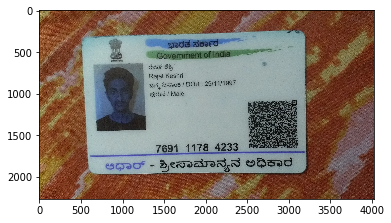

In [7]:
mult = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2, 3, 4, 0, 6, 7, 8, 9, 5], [2, 3, 4, 0, 1, 7, 8, 9, 5, 6],
        [3, 4, 0, 1, 2, 8, 9, 5, 6, 7], [4, 0, 1, 2, 3, 9, 5, 6, 7, 8], [5, 9, 8, 7, 6, 0, 4, 3, 2, 1],
        [6, 5, 9, 8, 7, 1, 0, 4, 3, 2], [7, 6, 5, 9, 8, 2, 1, 0, 4, 3], [8, 7, 6, 5, 9, 3, 2, 1, 0, 4],
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]
perm = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 5, 7, 6, 2, 8, 3, 0, 9, 4], [5, 8, 0, 3, 7, 9, 6, 1, 4, 2],
        [8, 9, 1, 6, 0, 4, 3, 5, 2, 7], [9, 4, 5, 3, 1, 2, 6, 8, 7, 0], [4, 2, 8, 6, 5, 7, 3, 9, 0, 1],
        [2, 7, 9, 3, 8, 0, 6, 4, 1, 5], [7, 0, 4, 6, 9, 1, 3, 2, 5, 8]]

#--------------------------------------------------------------------------------------------------------------------------

def Validate(aadharNum):
    try:
        i = len(aadharNum)
        j = 0
        x = 0

        while i > 0:
            i -= 1
            x = mult[x][perm[(j % 8)][int(aadharNum[i])]]
            j += 1
        if x == 0:
            return 'Valid Aadhar Number'
        else:
            return 'Invalid Aadhar Number'

    except ValueError:
        return 'Invalid Aadhar Number'
    except IndexError:
        return 'Invalid Aadhar Number'

Validate('769111784233')



'Valid Aadhar Number'

In [8]:
Validate('711571784233')

'Invalid Aadhar Number'

In [ ]:
# import the necessary packages
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import re
import io
import json
import ftfy
# from nostril import nonsense




##############################################################################################################
###################### Section 2: Load the image -- Preprocess it -- Write it to disk ########################
##############################################################################################################

# load the example image and convert it to grayscale
image = cv2.imread("rajataadhar.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# check to see if we should apply thresholding to preprocess the
# image

gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


'''
What we would like to do is to add some additional preprocessing steps as in most cases, you may need to scale your 
image to a larger size to recognize small characters. 
In this case, INTER_CUBIC generally performs better than other alternatives, though it’s also slower than others.
If you’d like to trade off some of your image quality for faster performance, 
you may want to try INTER_LINEAR for enlarging images.
'''
gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)



# make a check to see if blurring should be done to remove noise, first is default median blurring

'''
1. Gaussian Blurring works in a similar fashion to Averaging, but it uses Gaussian kernel, 
instead of a normalized box filter, for convolution. Here, the dimensions of the kernel and standard deviations 
in both directions can be determined independently. 
Gaussian blurring is very useful for removing — guess what? — 
gaussian noise from the image. On the contrary, gaussian blurring does not preserve the edges in the input.
2. In Median Blurring the central element in the kernel area is replaced with the median of all the pixels under the 
kernel. Particularly, this outperforms other blurring methods in removing salt-and-pepper noise in the images.
Median blurring is a non-linear filter. Unlike linear filters, median blurring replaces the pixel values 
with the median value available in the neighborhood values. So, median blurring preserves edges 
as the median value must be the value of one of neighboring pixels
3. Speaking of keeping edges sharp, bilateral filtering is quite useful for removing the noise without 
smoothing the edges. Similar to gaussian blurring, bilateral filtering also uses a gaussian filter 
to find the gaussian weighted average in the neighborhood. However, it also takes pixel difference into 
account while blurring the nearby pixels.
Thus, it ensures only those pixels with similar intensity to the central pixel are blurred, 
whereas the pixels with distinct pixel values are not blurred. In doing so, the edges that have larger 
intensity variation, so-called edges, are preserved.
'''


# write the grayscale image to disk as a temporary file so we can
# apply OCR to it
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)

'''
A blurring method may be applied. We apply a median blur when the --preprocess flag is set to blur. 
Applying a median blur can help reduce salt and pepper noise, again making it easier for Tesseract 
to correctly OCR the image.
After pre-processing the image, we use  os.getpid to derive a temporary image filename based on the process ID 
of our Python script.
The final step before using pytesseract for OCR is to write the pre-processed image, gray, 
to disk saving it with the filename  from above
'''

##############################################################################################################
######################################## Section 3: Running PyTesseract ######################################
##############################################################################################################


# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file
text = pytesseract.image_to_string(Image.open(filename), lang = 'eng')
# add +hin after eng within the same argument to extract hindi specific text - change encoding to utf-8 while writing
os.remove(filename)
# print(text)

# show the output images
# cv2.imshow("Image", image)
# cv2.imshow("Output", gray)
# cv2.waitKey(0)

# writing extracted data into a text file
text_output = open('outputbase.txt', 'w', encoding='utf-8')
text_output.write(text)
text_output.close()

file = open('outputbase.txt', 'r', encoding='utf-8')
text = file.read()
# print(text)

# Cleaning all the gibberish text
text = ftfy.fix_text(text)
text = ftfy.fix_encoding(text)
'''for god_damn in text:
    if nonsense(god_damn):
        text.remove(god_damn)
    else:
        print(text)'''
print(text)

############################################################################################################
###################################### Section 4: Extract relevant information #############################
############################################################################################################

# Initializing data variable
name = None
fname = None
dob = None
pan = None
nameline = []
dobline = []
panline = []
text0 = []
text1 = []
text2 = []

# Searching for PAN
lines = text.split('\n')
for lin in lines:
    s = lin.strip()
    s = lin.replace('\n','')
    s = s.rstrip()
    s = s.lstrip()
    text1.append(s)

text1 = list(filter(None, text1))
# print(text1)

'''
Note: Hindi has the worst error rates in tesseract and creates noise in image. Tesseract doesn't work well with noisy
data 
Reference: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35248.pdf
1. Income Tax Department Government of India (the text might be distorted due to quality of image or inherent problems
with tesseractocr and its inability to distinguish seamlessly between languages not native to the module or not as 
developed - such as Hindi.)
2. Name of the PAN Card Holder
3. Father's Name
4. Date of Birth in MM/DD/YYYY format as listed in the PAN Card
5. ----Permanent Account Number---- text that is a named entity in the PAN Card (not the actual PAN Card Number)
6. Permanent Account Number in the format ABCDE1234F
7. Signature as normal text - named entity in the PAN Card
'''

# to remove any text read from the image file which lies before the line 'Income Tax Department'

lineno = 0  # to start from the first line of the text file.

for wordline in text1:
    xx = wordline.split('\n')
    if ([w for w in xx if re.search('(INCOMETAXDEPARWENT @|mcommx|INCOME|TAX|GOW|GOVT|GOVERNMENT|OVERNMENT|VERNMENT|DEPARTMENT|EPARTMENT|PARTMENT|ARTMENT|INDIA|NDIA)$', w)]):
        text1 = list(text1)
        lineno = text1.index(wordline)
        break

# text1 = list(text1)
text0 = text1[lineno+1:]
print(text0)  # Contains all the relevant extracted text in form of a list - uncomment to check

def findword(textlist, wordstring):
    lineno = -1
    for wordline in textlist:
        xx = wordline.split( )
        if ([w for w in xx if re.search(wordstring, w)]):
            lineno = textlist.index(wordline)
            textlist = textlist[lineno+1:]
            return textlist
    return textlist

###############################################################################################################
######################################### Section 5: Dishwasher part ##########################################
###############################################################################################################

try:

    # Cleaning first names, better accuracy
    name = text0[0]
    name = name.rstrip()
    name = name.lstrip()
    name = name.replace("8", "B")
    name = name.replace("0", "D")
    name = name.replace("6", "G")
    name = name.replace("1", "I")
    name = re.sub('[^a-zA-Z] +', ' ', name)

    # Cleaning Father's name
    fname = text0[1]
    fname = fname.rstrip()
    fname = fname.lstrip()
    fname = fname.replace("8", "S")
    fname = fname.replace("0", "O")
    fname = fname.replace("6", "G")
    fname = fname.replace("1", "I")
    fname = fname.replace("\"", "A")
    fname = re.sub('[^a-zA-Z] +', ' ', fname)

    # Cleaning DOB
    dob = text0[2]
    dob = dob.rstrip()
    dob = dob.lstrip()
    dob = dob.replace('l', '/')
    dob = dob.replace('L', '/')
    dob = dob.replace('I', '/')
    dob = dob.replace('i', '/')
    dob = dob.replace('|', '/')
    dob = dob.replace('\"', '/1')
    dob = dob.replace(" ", "")

    # Cleaning PAN Card details
    text0 = findword(text1, '(Pormanam|Number|umber|Account|ccount|count|Permanent|ermanent|manent|wumm)$')
    panline = text0[0]
    pan = panline.rstrip()
    pan = pan.lstrip()
    pan = pan.replace(" ", "")
    pan = pan.replace("\"", "")
    pan = pan.replace(";", "")
    pan = pan.replace("%", "L")

except:
    pass

# Making tuples of data
data = {}
data['Name'] = name
data['Father Name'] = fname
data['Date of Birth'] = dob
data['PAN'] = pan

# print(data)

###############################################################################################################
######################################### Section 6: Write Data to JSONs ######################################
###############################################################################################################

# Writing data into JSON
try:
    to_unicode = unicode
except NameError:
    to_unicode = str

# Write JSON file
with io.open('data.json', 'w', encoding='utf-8') as outfile:
    str_ = json.dumps(data, indent=4, sort_keys=True, separators=(',', ': '), ensure_ascii=False)
    outfile.write(to_unicode(str_))

# Read JSON file
with open('data.json', encoding = 'utf-8') as data_file:
    data_loaded = json.load(data_file)

# print(data == data_loaded)

# Reading data back JSON(give correct path where JSON is stored)
with open('data.json', 'r', encoding= 'utf-8') as f:
    ndata = json.load(f)

print('\t', "|+++++++++++++++++++++++++++++++|")
print('\t', '|', '\t', ndata['Name'])
print('\t', "|-------------------------------|")
print('\t', '|', '\t', ndata['Father Name'])
print('\t', "|-------------------------------|")
print('\t', '|', '\t', ndata['Date of Birth'])
print('\t', "|-------------------------------|")
print('\t', '|', '\t', ndata['PAN'])
print('\t', "|+++++++++++++++++++++++++++++++|")


###########################################################################################################
###################             ##########  #####   ########        #######################################
###################  #####################   ####   ########  ##### #######################################
###################     ##################    ###   ########  ####  #######################################
###################     ##################     ##   ########  ####  #######################################
###################  #####################      #   ########  ##### #######################################
###################             ##########      #   ########        #######################################
###########################################################################################################